In [1]:
%load_ext autoreload
%autoreload 2

import plotting as plt

from data_utils import load_or_create_vocabulary
from train      import run_training
from inference  import reconstruct_smiles_table
import os
import data_utils as du

In [2]:
cfg = dict(
    # ---------------- data ----------------
    train_files = [
        "/home/md_halim_mondol/Data/Train_1.csv",
        "/home/md_halim_mondol/Data/Train_2.csv",
        "/home/md_halim_mondol/Data/Train_3.csv"],
    val_files   = ["/home/md_halim_mondol/Data/Valid_1.csv"],
    test_files  = ["/home/md_halim_mondol/Data/Test.csv"],
    seq_length  = 160,
    n_train     = 250000,   # number of training examples
    n_val       = 80000,    # number of validation examples

    # ---------------- model ----------------
    d_model     = 256,
    latent_dim  = 64,   # latent dimension
    n_head      = 8,
    enc_layers  = 7,
    dec_layers  = 7,
    ff_dim      = 1024,
    dropout     = 0.05,
    emb_dropout = 0.05,

    # special token indices (match your vocabulary)
    pad_idx     = 0,
    sos_idx     = 2,
    eos_idx     = 3,

    # -------------- optimization --------------
    batch       = 512,
    lr          = 1e-4,
    weight_decay= 1e-4,
    epochs      = 50,
    early_stop  = 10,
    early_stop_min_delta = 1e-4,
    clip_grad   = 1.0,

    # -------------- schedules --------------
    kl_anneal   = 15,
    kl_max      = 0.02,

    # -------- regularization tweaks --------
    label_smoothing = 0.02,   # 0.0 to disable
    corruption_p     = 0.05,  # word-dropout on decoder inputs (train only)

    # -------- validation / decoding --------
    beam_every  = 5,   # run beam metrics every N epochs
    beam_size   = 5,

    # ---------------- I/O ----------------
    save_dir    = "./checkpoints",
    save_every  = 10,   # periodic checkpointing

    # -------- (optional) LR scheduler ------
    plateau = dict(mode="min", factor=0.3, patience=3, verbose=True, min_lr=0.0, threshold=1e-4),
)

In [3]:
all_csvs = cfg["train_files"] + cfg["val_files"] + cfg["test_files"]
token_to_idx, idx_to_token = load_or_create_vocabulary(all_csvs, cache_path="vocab.json", test_smiles=None)

assert token_to_idx["<PAD>"] == cfg["pad_idx"], "PAD index mismatch with cached vocab"
assert token_to_idx["<SOS>"] == cfg["sos_idx"], "SOS index mismatch with cached vocab"
assert token_to_idx["<EOS>"] == cfg["eos_idx"], "EOS index mismatch with cached vocab"
print("Vocab size:", len(token_to_idx))
print(token_to_idx)
print("Special tokens:")
print("PAD:", token_to_idx["<PAD>"])
print("SOS:", token_to_idx["<SOS>"])
print("EOS:", token_to_idx["<EOS>"])

[vocab] loaded cached vocabulary from vocab.json (49 tokens)
Vocab size: 49
{'<PAD>': 0, '<UNK>': 1, '<SOS>': 2, '<EOS>': 3, 'O': 4, '=': 5, 'C': 6, '1': 7, 'N': 8, '[C@@H]': 9, '[NH+]': 10, '(': 11, 'c': 12, '2': 13, ')': 14, '(=O)': 15, 'S': 16, '3': 17, 'n': 18, '-': 19, '[C@H]': 20, '4': 21, 's': 22, '[': 23, ']': 24, 'F': 25, '#': 26, 'H': 27, '[nH+]': 28, 'Cl': 29, 'o': 30, '[NH2+]': 31, '@': 32, '+': 33, 'Br': 34, '[O-]': 35, '[N-]': 36, '/': 37, '\\': 38, '5': 39, 'I': 40, '6': 41, '[N+]': 42, '7': 43, 'p': 44, '.': 45, 'P': 46, '8': 47, '9': 48}
Special tokens:
PAD: 0
SOS: 2
EOS: 3


In [4]:
model, history = run_training(cfg, token_to_idx, idx_to_token)

Using device: cuda
Visible CUDA devices: 2


/home/md_halim_mondol/anaconda3/envs/cheminf/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/md_halim_mondol/LSTM_VAE_Paper/train.py:148: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/home/md_halim_mondol/anaconda3/envs/cheminf/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/home/md_halim_mondol/LSTM_VAE_Paper/train.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.

Epoch  1: train 1.6003/0.526  val(tf) 1.0064/0.662  KL 0.00
Epoch  2: train 1.1446/0.652  val(tf) 0.7420/0.747  KL 0.00
Epoch  3: train 0.9850/0.703  val(tf) 0.5884/0.792  KL 0.00
Epoch  4: train 0.8873/0.736  val(tf) 0.4927/0.825  KL 0.01
Epoch  5: train 0.8158/0.763  val(tf) 0.4276/0.855  beam_acc 0.515  valid 0.500  lev 12.28  KL 0.01
Epoch  6: train 0.7601/0.785  val(tf) 0.3731/0.874  KL 0.01
Epoch  7: train 0.7139/0.804  val(tf) 0.3236/0.894  KL 0.01
Epoch  8: train 0.6756/0.819  val(tf) 0.3017/0.902  KL 0.01
Epoch  9: train 0.6459/0.832  val(tf) 0.2813/0.912  KL 0.01
Epoch 10: train 0.6197/0.843  val(tf) 0.2642/0.918  beam_acc 0.686  valid 0.693  lev 6.73  KL 0.01
Epoch 11: train 0.5955/0.854  val(tf) 0.2390/0.931  KL 0.01
Epoch 12: train 0.5729/0.864  val(tf) 0.2323/0.934  KL 0.02
Epoch 13: train 0.5538/0.873  val(tf) 0.2245/0.938  KL 0.02
Epoch 14: train 0.5377/0.880  val(tf) 0.2148/0.940  KL 0.02
Epoch 15: train 0.5231/0.887  val(tf) 0.1987/0.949  beam_acc 0.812  valid 0.807  

[plot] saved to ./checkpoints/training_curves.png


(<Figure size 1500x800 with 6 Axes>,
 array([[<Axes: title={'center': 'Loss (TF)'}, ylabel='CE+KL'>,
         <Axes: title={'center': 'Token Acc (TF)'}>,
         <Axes: title={'center': 'Token Acc (Beam)'}>],
        [<Axes: title={'center': 'Validity Ratio (Beam)'}, xlabel='epoch'>,
         <Axes: title={'center': 'Levenshtein (Beam)'}, xlabel='epoch'>,
         <Axes: xlabel='epoch'>]], dtype=object))

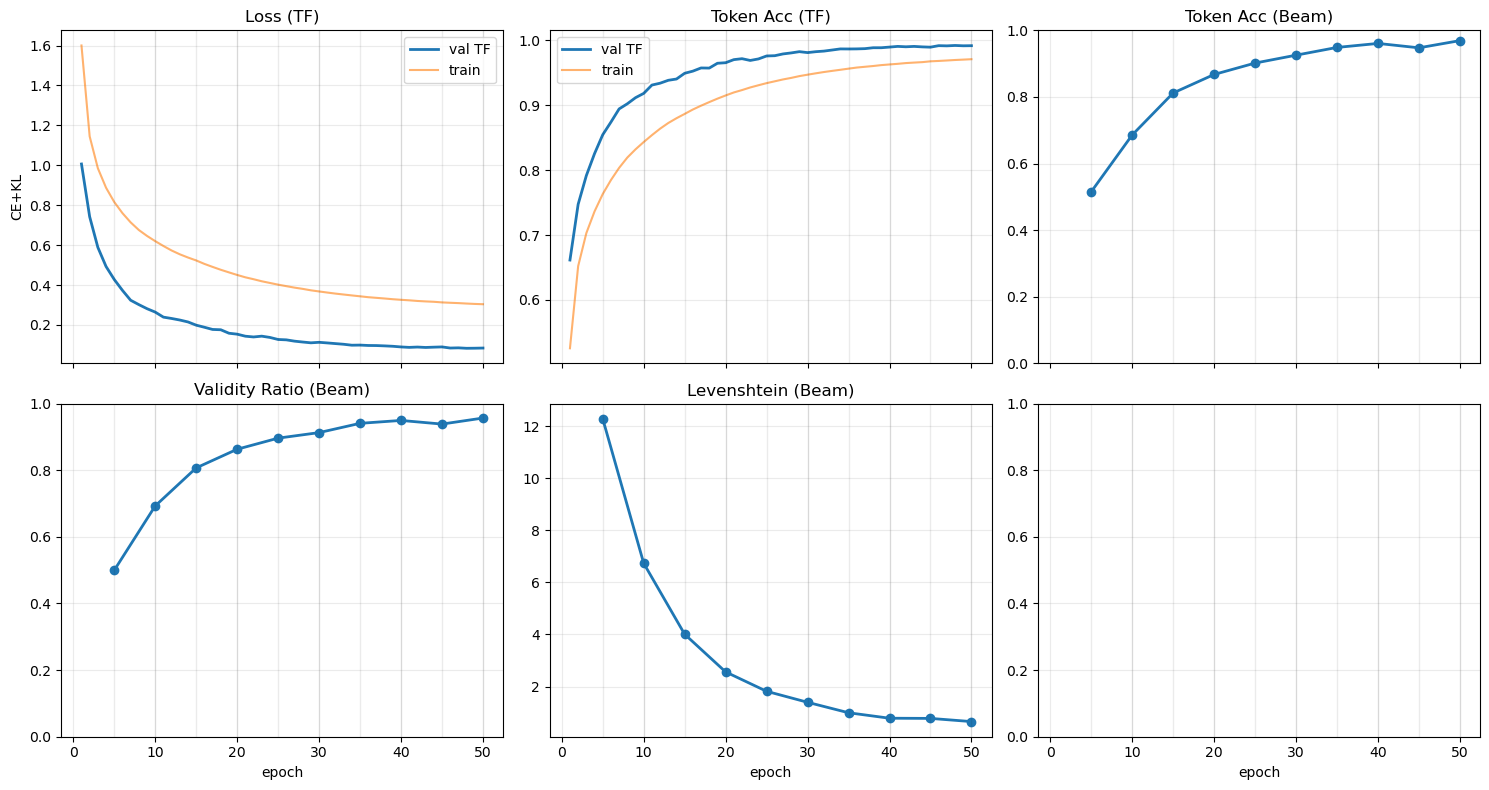

In [5]:
plt.plot_training_curves(history, beam_every=cfg["beam_every"], save_path=os.path.join(cfg["save_dir"], "training_curves.png"))

In [6]:
# # ─── Cell 5 : SMILES reconstruction demo ─────────────────────────────────────

Dye_smiles = [
'CC1=CC(=O)c2c(Br)cc(Br)c(S(=O)(=O)O)c2C1=O',
'Cc1c(Br)cc(Br)c(C(C)c2ccc(C(C)C)c(Br)c2O)c1S(=O)(=O)O',
'Cc1ccccc1N=Nc1ccc(C(N)=O)cc1',
'Cc1ccc(-c2cccc(O)c2C(C)c2ccc(S(=O)(=O)O)cc2)cc1',
'CN(C)c1ccc2c(c1)CN=C2c1ccccc1',
'O=C1c2ccccc2C(=O)c2c(O)cccc21',
'O=C1Nc2ccccc2S(=O)(=O)[N-]c2c1cccc2S(=O)(=O)[O-]',
'CN(C)C1=CS(=O)(=O)c2ccc(N(C)C)cc21',
'CN(C)c1ccc(C(C)(c2ccc(N(C)C)cc2)c2ccc(N(C)C)cc2)cc1',
'Cc1ccc(C(c2ccc(O)cc2)(c2ccc(O)cc2)c2ccc(C(C)C)cc2)cc1',
'CN(C)c1ccc2c(c1)CC1=CC(=[N+](C)C)C(=N2)C=C1',
'O=C1c2cc(=O)cccc2C(=O)c2c(Br)cc(Br)cc21',
'O=c1cc(O)ccc(-c2ccc3c(oc(=O)c4ccccc43)c2O)c1']


# Dye_names = [
#     'Bromophenol Blue',
#     'Bromothymol Blue',
#     'Acetic acid',
#     'Phenol Red',
#     'Neutral Red',
#     'Alizarin Red S',
#     'Indigo Carmine',
#     'Methylene Blue',
#     'Crystal Violet',
#     'Thymolphthalein',
#     'Safranin O',
#     'Eosin Y',
#     'Fluorescein']


# test_csv=cfg["test_files"][0]
# smiles_list=Dye_smiles,

In [7]:
import torch, torch.nn as nn

m = model.module if isinstance(model, nn.DataParallel) else model
device = next(m.parameters()).device

df_rec = reconstruct_smiles_table(
    smiles_list=None,
    test_csv=cfg["test_files"][0],
    model=m,
    token_to_idx=token_to_idx,
    idx_to_token=idx_to_token,
    seq_length=cfg["seq_length"],
    pad_idx=cfg["pad_idx"],
    sos_idx=cfg["sos_idx"],
    eos_idx=cfg["eos_idx"],
    device=device,
    mode="beam",
    beam_size=cfg["beam_size"])

df_rec.tail(20)

/home/md_halim_mondol/anaconda3/envs/cheminf/lib/python3.10/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


,input,reconstructed,valid,lev
249,COC(=O)Cn1c(CCNC(=O)c2ccccc2)[nH+]c2ccccc21,COC(=O)Cn1c(CCNC(=O)c2ccccc2)[nH+]c2ccccc21,yes,0
250,CC(C)=CC(=O)NCc1cc[nH+]c(N2CCO[C@@H](C)C2)c1,CC(C)=CC(=O)NCc1cc[nH+]c(N2CCO[C@@H](C)C2)c1,yes,0
251,[NH3+]CC1([C@H](O)c2ccccc2OC(F)F)CCC1,[NH3+]CC1([C@H](O)c2ccccc2OC(F)F)CCC1,yes,0
252,COC(=O)c1nn(CC(=O)NCCc2ccc(OC)c(OC)c2)c(=O)c2n...,COC(=O)c1nn(CC(=O)NCCc2ccc(OC)c(OC)c2)c(=O)c2n...,yes,0
253,Cc1cnc(NC(=O)N[C@@H](C)c2ccc(S(=O)(=O)N(C)C)cc...,Cc1cnc(NC(=O)N[C@@H](C)c2ccc(S(=O)(=O)N(C)C)cc...,yes,0
254,CCOC(=O)c1cnn([C@H]2CCCN(C(=O)Nc3cccc(N(C)CC)c...,CCOC(=O)c1cnn([C@H]2CCCN(C(=O)Nc3cccc(N(C)CC)c...,yes,0
255,CCCCNC(=O)[C@H]1[C@H]2C=C[C@]3(CN(c4cc(C)on4)C...,CCCCNC(=O)[C@H]1[C@H]2C=C[C@]3(CN(c4cc(C)on4)C...,yes,0
256,CC(C)[C@@H]1CN(Cc2c[nH]nc2-c2ccc(Cl)cc2)C[C@H]...,CC(C)[C@@H]1CN(Cc2c[nH]nc2-c2ccc(Cl)cc2)C[C@H]...,yes,0
257,CC(C)N(Cc1ccc(Cl)nc1)C[C@H]1CCCCO1,CC(C)N(Cc1ccc(Cl)nc1)C[C@H]1CCCCO1,yes,0
258,c1ccc(-c2nc(CN3CCC[C@H]3c3ccccc3)no2)cc1,c1ccc(-c2nc(CN3CCC[C@H]3c3ccccc3)no2)cc1,yes,0


In [8]:

# ------------------------------------------------------------------
# 1.  Token-level accuracy (micro-average over SMILES tokens)
# ------------------------------------------------------------------
def token_accuracy_row(gold, pred):
    g = du.tokenize_smiles(gold)
    p = du.tokenize_smiles(pred)
    L = min(len(g), len(p))
    if L == 0:                      # degenerate empty case
        return 0, 0
    correct = sum(gi == pi for gi, pi in zip(g[:L], p[:L]))
    total   = L
    return correct, total

tot_corr = tot_tok = 0
for g, p in zip(df_rec["input"], df_rec["reconstructed"]):
    c, t = token_accuracy_row(g, p)
    tot_corr += c
    tot_tok  += t

beam_token_acc = tot_corr / tot_tok if tot_tok else 0.0
print(f"Token level test accuracy (beam): {beam_token_acc:.4f}")

# ------------------------------------------------------------------
# 2.  Sequence-level (exact-match) accuracy
# ------------------------------------------------------------------
exact_match_acc = (df_rec["input"] == df_rec["reconstructed"]).mean()
print(f"Exact SMILES match accuracy (beam): {exact_match_acc:.4f}")

Token level test accuracy (beam): 0.9730
Exact SMILES match accuracy (beam): 0.8401


In [9]:
df_rec = reconstruct_smiles_table(
    smiles_list=Dye_smiles,
    test_csv=None,
    model=m,
    token_to_idx=token_to_idx,
    idx_to_token=idx_to_token,
    seq_length=cfg["seq_length"],
    pad_idx=cfg["pad_idx"],
    sos_idx=cfg["sos_idx"],
    eos_idx=cfg["eos_idx"],
    device=device,
    mode="beam",
    beam_size=cfg["beam_size"])

df_rec.head(20)

/home/md_halim_mondol/anaconda3/envs/cheminf/lib/python3.10/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


,input,reconstructed,valid,lev
0,CC1=CC(=O)c2c(Br)cc(Br)c(S(=O)(=O)O)c2C1=O,CC1=CC(=O)c2c(Br)cc(Br)c(S(=O)(=O)O)c2C1=O,yes,0
1,Cc1c(Br)cc(Br)c(C(C)c2ccc(C(C)C)c(Br)c2O)c1S(=...,Cc1c(Br)cc(Br)c(C(Cc2ccc(C)c(CC)c2)=O)c(O)c1S(...,no,10
2,Cc1ccccc1N=Nc1ccc(C(N)=O)cc1,Cc1ccccc1N=Nc1ccc(C(N)=O)cc1,yes,0
3,Cc1ccc(-c2cccc(O)c2C(C)c2ccc(S(=O)(=O)O)cc2)cc1,Cc1ccc(-c2cccc(O)c2C(C)c2ccc(S(=O)(=O)O)cc2)cc1,yes,0
4,CN(C)c1ccc2c(c1)CN=C2c1ccccc1,CN(C)c1ccc2c(c1)CN=C2c1ccccc1,yes,0
5,O=C1c2ccccc2C(=O)c2c(O)cccc21,O=C1c2ccccc2C(=O)c2c(O)cccc21,yes,0
6,O=C1Nc2ccccc2S(=O)(=O)[N-]c2c1cccc2S(=O)(=O)[O-],O=C1Nc2ccccc2S(=O)(=O)[N-]c2ccccc2S1(=O)(=O)[O-],no,2
7,CN(C)C1=CS(=O)(=O)c2ccc(N(C)C)cc21,CN(C)C1=CS(=O)(=O)c2ccc(N(C)C)cc2)C1,no,2
8,CN(C)c1ccc(C(C)(c2ccc(N(C)C)cc2)c2ccc(N(C)C)cc...,CN(C)c1ccc(C(C)(c2ccc(N(C)C)cc2)c2ccc(N(C)C)cc...,yes,0
9,Cc1ccc(C(c2ccc(O)cc2)(c2ccc(O)cc2)c2ccc(C(C)C)...,Cc1ccc(C(c2ccc(O)cc2)(c2ccc(O)cc2)c2ccc(C(C)C)...,yes,0


In [10]:
tot_corr = tot_tok = 0
for g, p in zip(df_rec["input"], df_rec["reconstructed"]):
    c, t = token_accuracy_row(g, p)
    tot_corr += c
    tot_tok  += t

beam_token_acc = tot_corr / tot_tok if tot_tok else 0.0
print(f"Token level test accuracy for Dye SMILES (beam): {beam_token_acc:.4f}")

# ------------------------------------------------------------------
# 2.  Sequence-level (exact-match) accuracy
# ------------------------------------------------------------------
exact_match_acc = (df_rec["input"] == df_rec["reconstructed"]).mean()
print(f"Exact SMILES match accuracy for Dye SMILES (beam): {exact_match_acc:.4f}")

Token level test accuracy for Dye SMILES (beam): 0.8581
Exact SMILES match accuracy for Dye SMILES (beam): 0.6154
